In [2]:
!apt-get install -y openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-5build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from openslide import open_slide

In [4]:
slide = open_slide("/content/wsi_img.svs")

In [5]:
level = 1  #Use 0, was used to load faster
slide_dimensions = slide.level_dimensions[level]
slide_region = slide.read_region((0, 0), level, slide_dimensions)

In [6]:
wsi_img = np.array(slide_region)
wsi_img.shape

(4239, 3500, 4)

In [7]:
wsi_img_resized = cv2.resize(wsi_img, (3500, 3500)) #Use 14k, was set to 1500 for faster loading

In [ ]:
#wsi_img_rgb = wsi_img_resized[:, :, :3]
#wsi_img_rgb.shape #removed Alpha Channel

In [8]:
wsi_img_rgb = cv2.cvtColor(wsi_img_resized, cv2.COLOR_BGR2RGB) # Convert to gray just for seeing it
wsi_img_rgb.shape

(3500, 3500, 3)

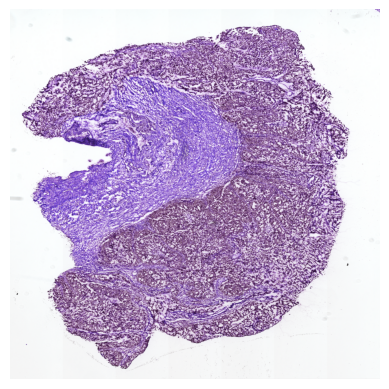

In [9]:
plt.axis('off')
plt.imshow(wsi_img_rgb) #cmap="gray"
plt.show()

In [10]:
Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)

In [11]:
HERef = np.array([[0.5626, 0.2159],
                  [0.7201, 0.8012],
                  [0.4062, 0.5581]])

In [12]:
maxCRef = np.array([1.9705, 1.0308])

In [13]:
h, w, c = wsi_img_rgb.shape

In [14]:
wsi_img_rgb = wsi_img_rgb.reshape((-1,3))

In [15]:
OD = -np.log10((wsi_img_rgb.astype(np.float64)+1)/Io)

This Cell is used to Visualize the image that was converted to Optical Dimension. Takes a lot of time to run Don't run unless you wan't to see it.

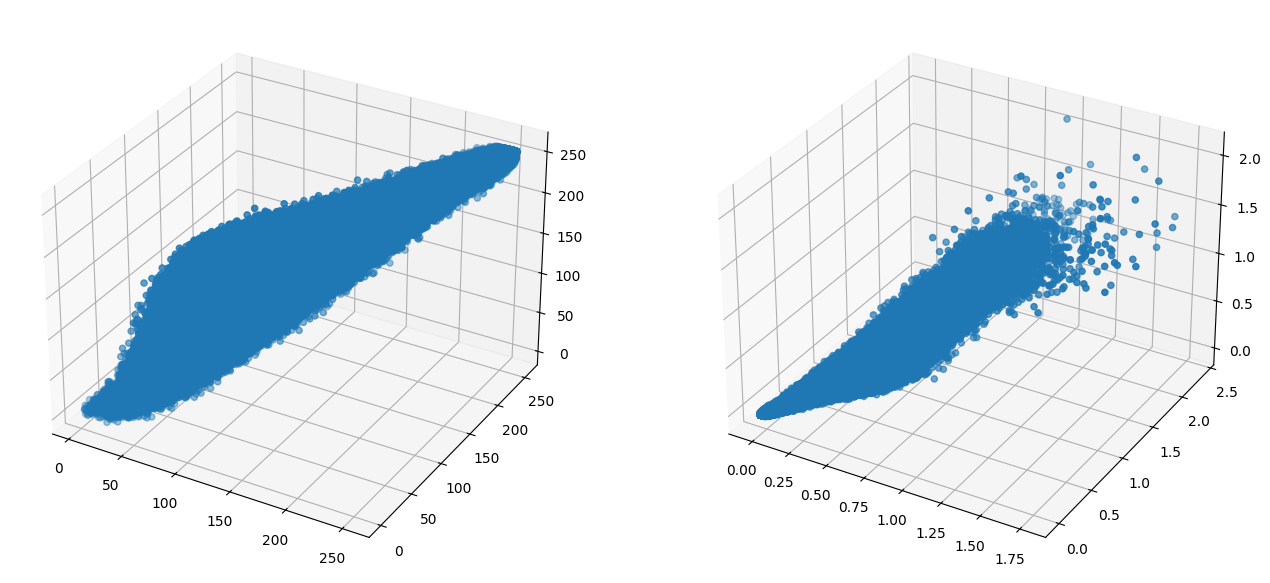

In [16]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(wsi_img_rgb[:,0],wsi_img_rgb[:,1],wsi_img_rgb[:,2])
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(OD[:,0],OD[:,1],OD[:,2])
plt.show()

In [17]:
ODhat = OD[~np.any(OD < beta, axis=1)]

In [18]:
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

In [19]:
That = ODhat.dot(eigvecs[:,1:3])

In [20]:
phi = np.arctan2(That[:,1],That[:,0])

In [21]:
minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)

In [22]:
vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)

In [23]:
if vMin[0] > vMax[0]:
    HE = np.array((vMin[:,0], vMax[:,0])).T

else:
    HE = np.array((vMax[:,0], vMin[:,0])).T

In [24]:
Y = np.reshape(OD, (-1, 3)).T

In [25]:
C = np.linalg.lstsq(HE,Y, rcond=None)[0]

In [26]:
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])

In [27]:
Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm[Inorm>255] = 254
Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)

In [28]:
H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

In [29]:
E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
E[E>255] = 254
E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)


In [30]:
plt.imsave("HnE_normalized.jpg", Inorm)
plt.imsave("HnE_separated_H.jpg", H)
plt.imsave("HnE_separated_E.jpg", E)